In [1]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath(''))
root = dirname.parent

sys.path.insert(0, str(root))

import torch

torch.__version__

'1.8.0'

## HyperParameters & Configurations

In [2]:
NORMALIZE_DATA = True
WINDOW_SIZE = 10
Y_DIM = 1
ENCODER_HIDDEN_STATES = 128
DECODER_HIDDEN_STATES = 128
BATCH_SIZE = 256
EPOCHS = 100
VALIDATION_RATIO = 0.2
DROPOUT = 0

## Read NASDAQ 100 raw data

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

raw_data =  pd.read_csv('./nasdaq100_padding.csv').values

scale = StandardScaler().fit(raw_data)

if NORMALIZE_DATA:
    data = scale.transform(raw_data)
else:
    data = raw_data

In [4]:
from notebook.common import split_data
from torch.utils.data import TensorDataset, DataLoader


def to_tensor(array):
    return torch.from_numpy(array).float()
    

train_X, train_y, val_X, val_y = split_data(data, to_tensor, WINDOW_SIZE, Y_DIM, VALIDATION_RATIO)

print('train_X, train_y :', train_X.shape, train_y.shape)
print('  val_X,   val_y :', val_X.shape, val_y.shape)

train_X, train_y : torch.Size([32439, 10, 82]) torch.Size([32439, 1])
  val_X,   val_y : torch.Size([8103, 10, 82]) torch.Size([8103, 1])


In [8]:
from da_rnn.torch import DARNN, DEVICE
from poutyne import Model, EarlyStopping

darnn = DARNN(
    n=train_X.shape[2] - 1,
    T=WINDOW_SIZE,
    m=ENCODER_HIDDEN_STATES,
    p=DECODER_HIDDEN_STATES,
    y_dim=Y_DIM,
    dropout=DROPOUT
)

model = Model(
    darnn,
    'adam',
    'mse',
    device=DEVICE
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5)
    ]
)

Epoch:   1/100 Train steps: 127 Val steps: 32 53.91s loss: 0.202221 val_loss: 0.023179
Epoch:   2/100 Train steps: 127 Val steps: 32 54.05s loss: 0.003696 val_loss: 0.017915
Epoch:   3/100 Train steps: 127 Val steps: 32 53.86s loss: 0.003701 val_loss: 0.008593
Epoch:   4/100 Train steps: 127 Val steps: 32 53.53s loss: 0.003218 val_loss: 0.007235
Epoch:   5/100 Train steps: 127 Val steps: 32 54.27s loss: 0.003174 val_loss: 0.009080
Epoch:   6/100 Train steps: 127 Val steps: 32 54.24s loss: 0.002903 val_loss: 0.006759
Epoch:   7/100 Train steps: 127 Val steps: 32 54.14s loss: 0.002650 val_loss: 0.004077
Epoch:   8/100 Train steps: 127 Val steps: 32 54.04s loss: 0.002418 val_loss: 0.004940
Epoch:   9/100 Train steps: 127 Val steps: 32 54.23s loss: 0.002171 val_loss: 0.003000
Epoch:  10/100 Train steps: 127 Val steps: 32 54.72s loss: 0.001791 val_loss: 0.003242
Epoch:  11/100 Train steps: 127 Val steps: 32 54.13s loss: 0.001479 val_loss: 0.002841
Epoch:  12/100 Train steps: 127 Val steps: 

[{'epoch': 1,
  'loss': 0.20222133155093638,
  'time': 53.90815326400002,
  'val_loss': 0.02317921679426046},
 {'epoch': 2,
  'loss': 0.003696246907463981,
  'time': 54.05044278500009,
  'val_loss': 0.017915215352891506},
 {'epoch': 3,
  'loss': 0.003701367056462469,
  'time': 53.863766924000174,
  'val_loss': 0.008592548149951766},
 {'epoch': 4,
  'loss': 0.0032184342439942576,
  'time': 53.53238045100011,
  'val_loss': 0.007234940218748292},
 {'epoch': 5,
  'loss': 0.0031744009558446304,
  'time': 54.27216710000016,
  'val_loss': 0.00908023650250758},
 {'epoch': 6,
  'loss': 0.002903179079281285,
  'time': 54.239767606999976,
  'val_loss': 0.0067592733810888745},
 {'epoch': 7,
  'loss': 0.002650225642898474,
  'time': 54.13992672899985,
  'val_loss': 0.0040766811740516745},
 {'epoch': 8,
  'loss': 0.0024184659196128705,
  'time': 54.036730441000145,
  'val_loss': 0.004940427523568378},
 {'epoch': 9,
  'loss': 0.0021711921822737327,
  'time': 54.22911317299986,
  'val_loss': 0.0030004

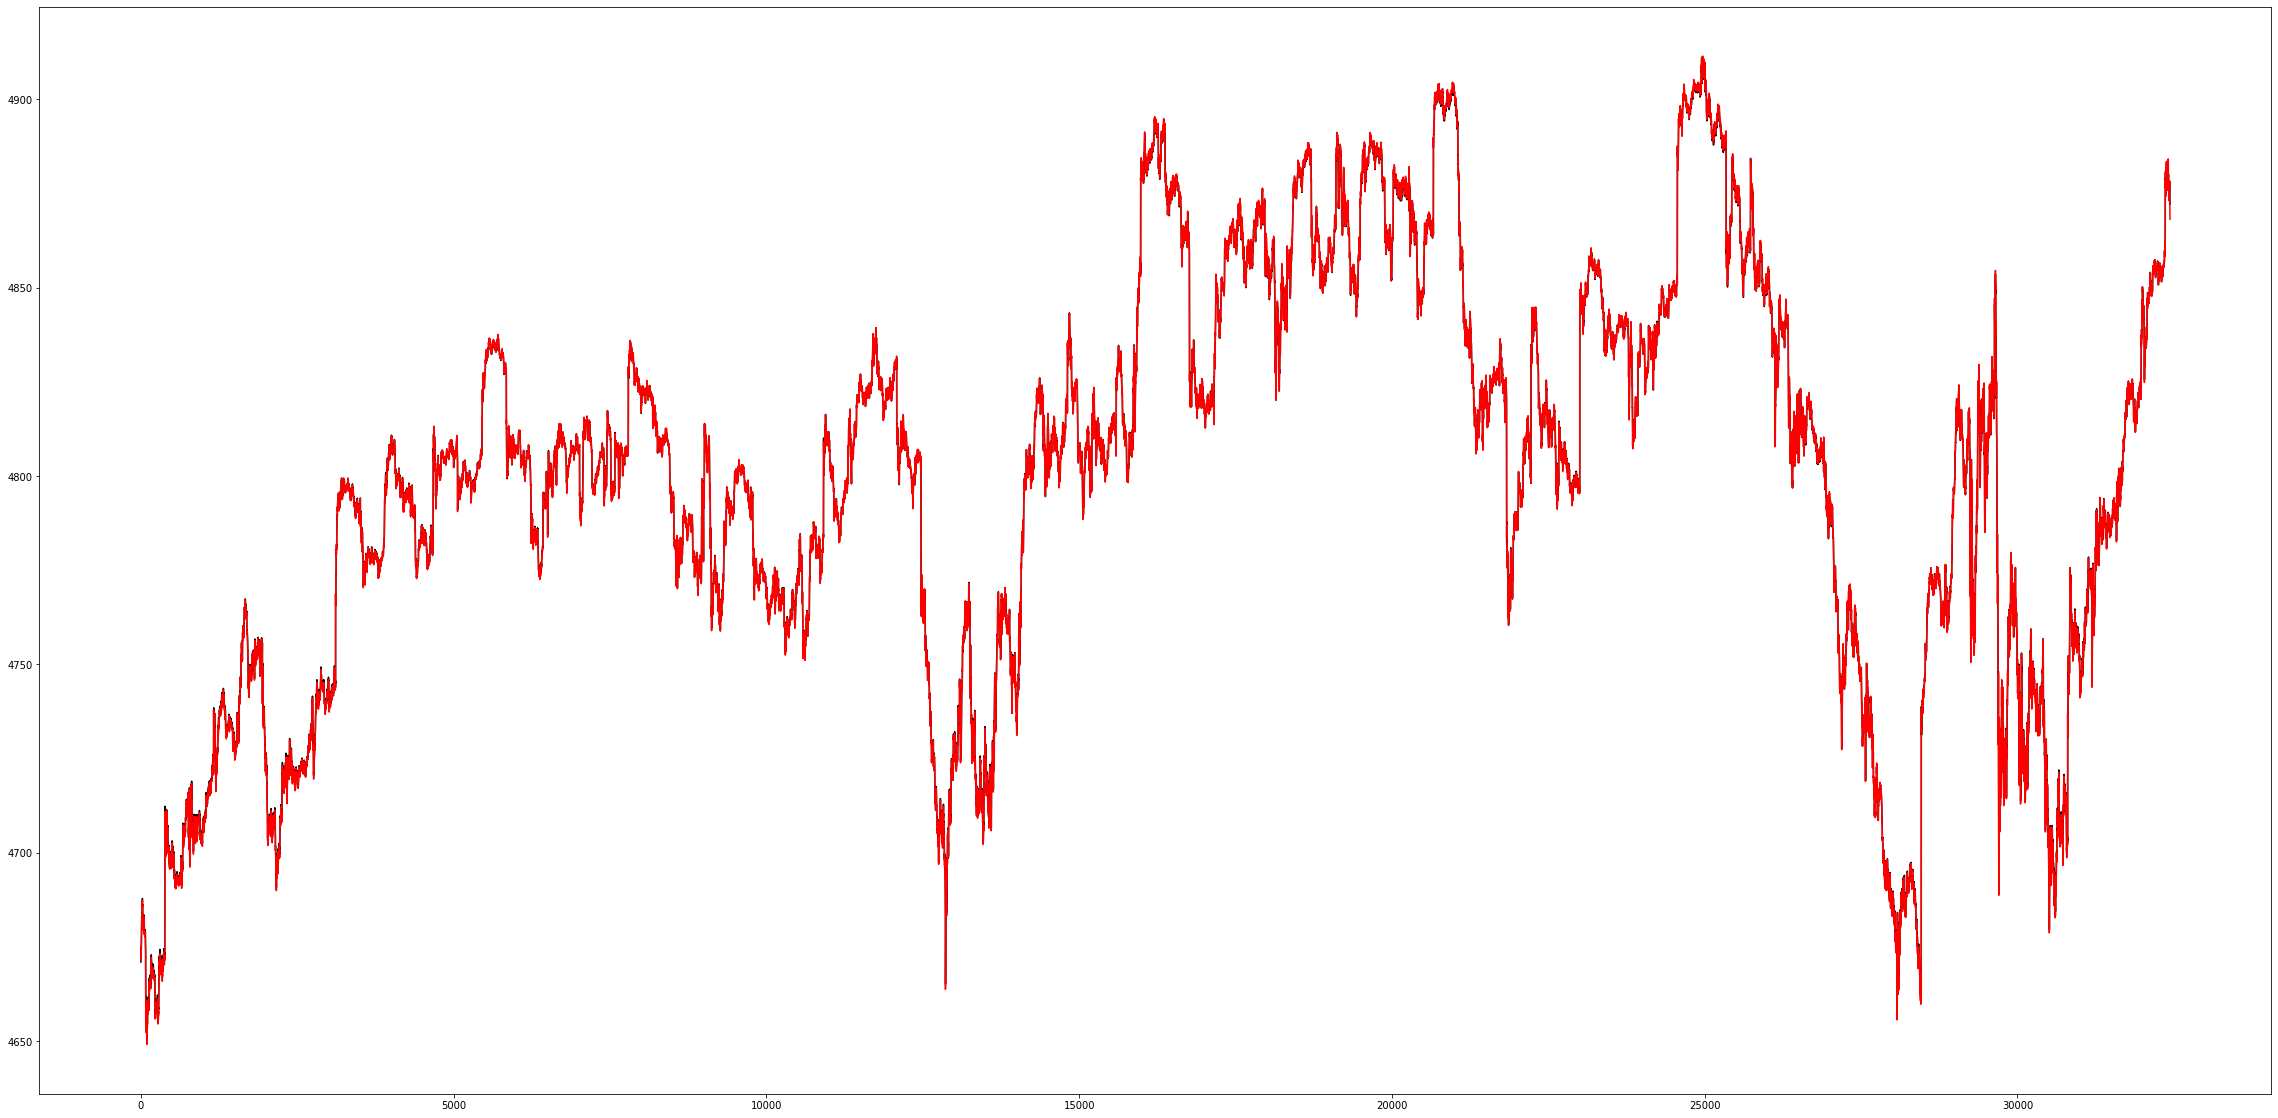

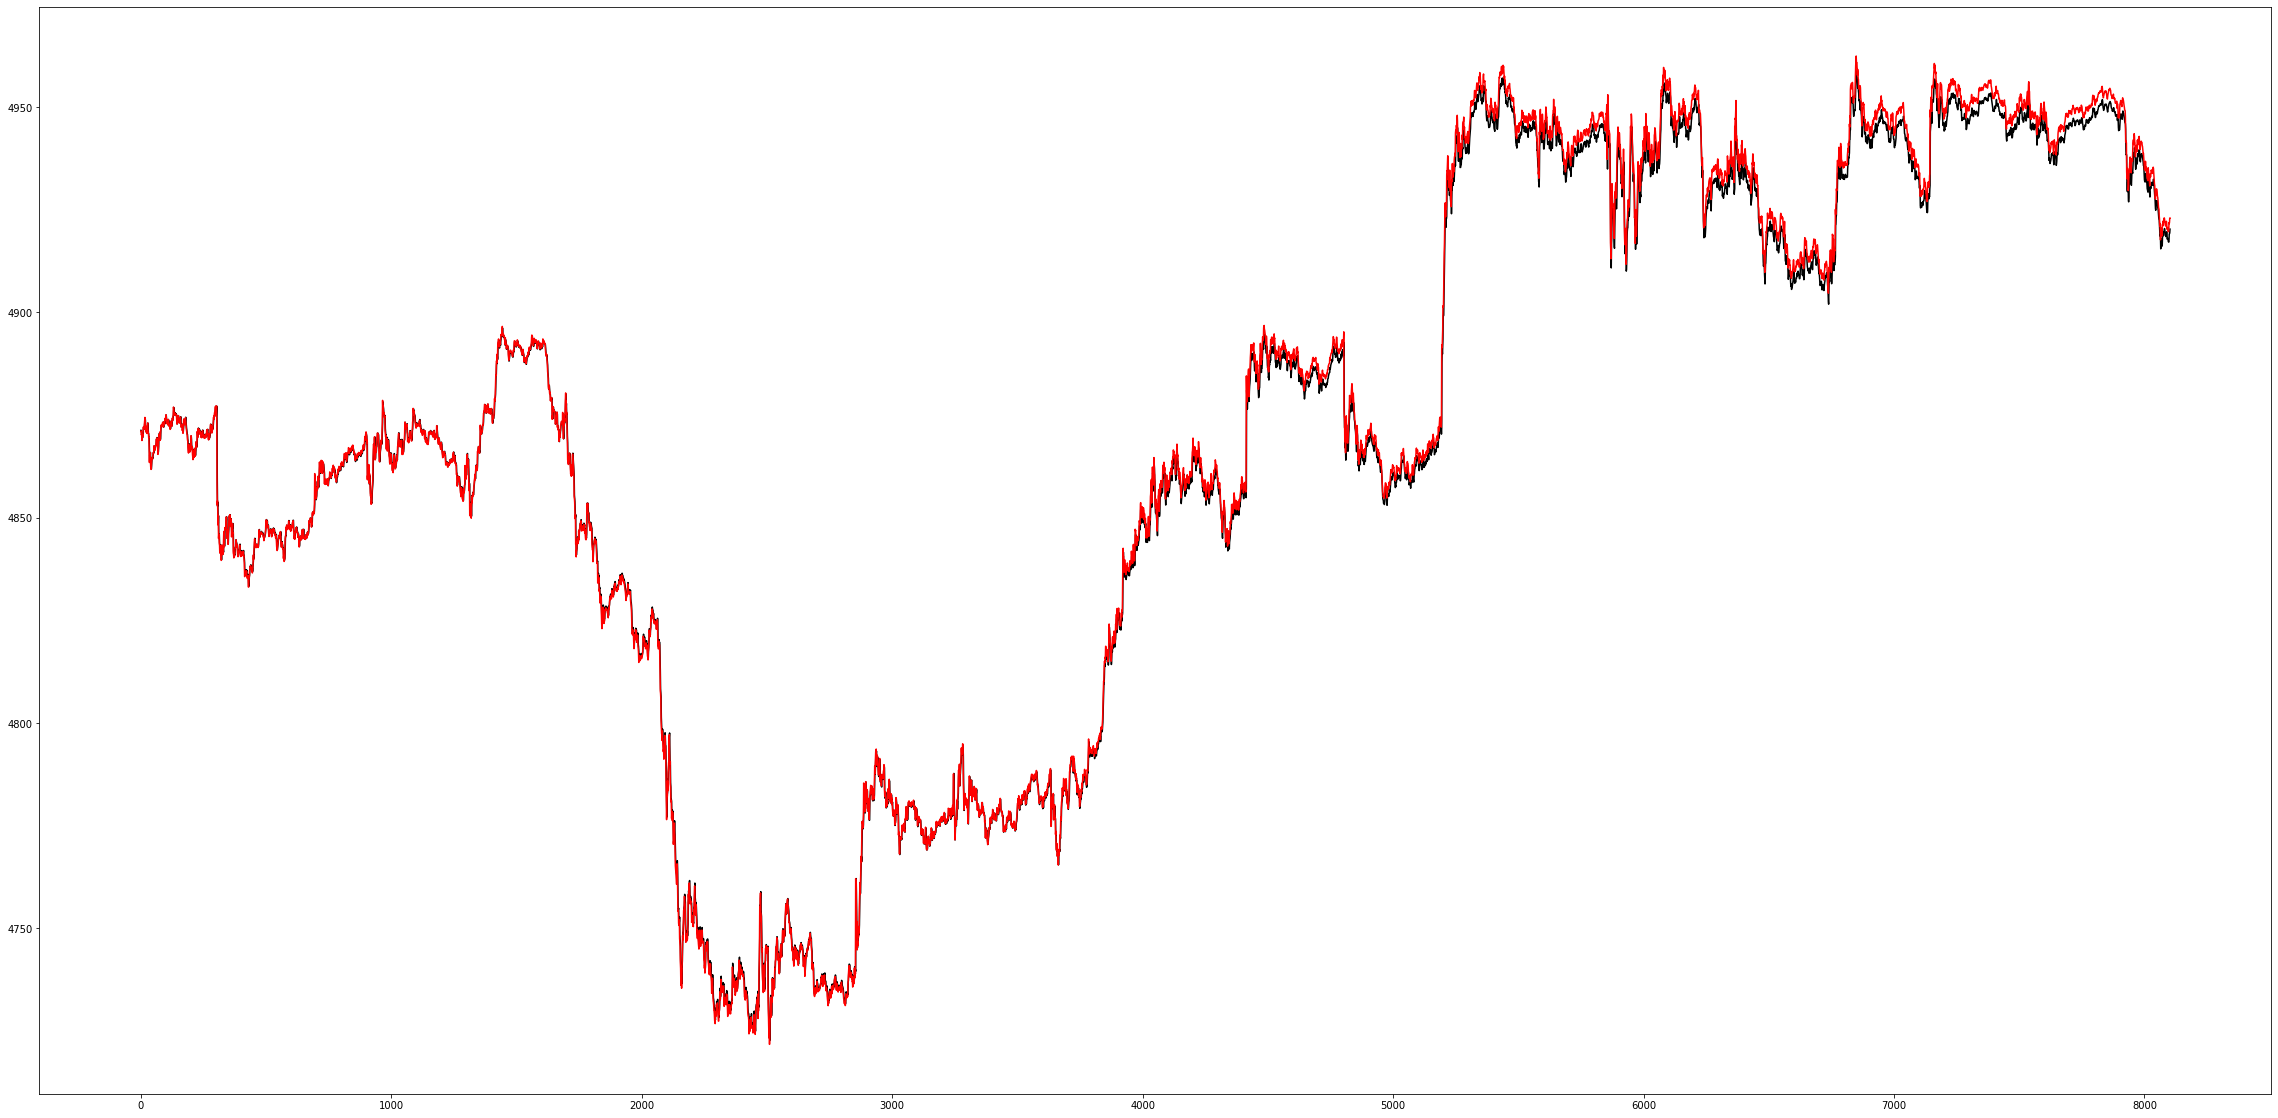

In [12]:
import matplotlib.pyplot as plt


def predict(model, X):
    with torch.no_grad():
        return model(X)
    

train_y_hat = predict(darnn, train_X)
plt.figure(figsize=(40,20))
plt.plot(
    scale.inverse_transform(train_y_hat.cpu().repeat(1,82).numpy())[:,-1],
    'k',
    scale.inverse_transform(train_y.repeat(1,82).numpy())[:,-1],
    'r'
)

# see the prediction of new data
val_y_hat = predict(darnn, val_X)
plt.figure(figsize=(40,20))
plt.plot(
    scale.inverse_transform(val_y_hat.cpu().repeat(1,82).numpy())[:,-1],
    'k',
    scale.inverse_transform(val_y.repeat(1,82).numpy())[:,-1],
    'r'
)